### Import requires libraries

In [1]:
from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt

### Setting up the input and output files
We declare the path for the raster bands and the output NDVI and land cover change rasters. The land cover change contour shape path is also defined.

In [2]:
#Input Raster and Vector Paths

#Image-2019
path_B5_2019="../Image20190203clip/LC08_L1TP_029047_20190203_20190206_01_T1_B5_clip.TIF"
path_B4_2019="../Image20190203clip/LC08_L1TP_029047_20190203_20190206_01_T1_B4_clip.TIF"

#Image-2014
path_B5_2014="../Image20140205clip/LC08_L1TP_029047_20140205_20170307_01_T1_B5_clip.TIF"
path_B4_2014="../Image20140205clip/LC08_L1TP_029047_20140205_20170307_01_T1_B4_clip.TIF"


In [3]:
#Output Files

#Output NDVI Rasters 
path_NDVI_2019 = '../Output/NDVI2019.tif'
path_NDVI_2014 = '../Output/NDVI2014.tif'
path_NDVIChange_19_14 = '../Output/NDVIChange_19_14.tif'

#NDVI Contours
contours_NDVIChange_19_14 = '../Output/NDVIChange_19_14.shp'

### Open the Landsat image bands with GDAL 
In this part we open the red (Band 4) and near infrared NIR (Band 5) with commands of the GDAL library and then we read the images as matrix arrays with float numbers of 32 bits.

In [4]:
#Open raster bands
B5_2019 = gdal.Open(path_B5_2019)
B4_2019 = gdal.Open(path_B4_2019)
B5_2014 = gdal.Open(path_B5_2014)
B4_2014 = gdal.Open(path_B4_2014)

#Read bands as matrix arrays
B52019_Data = B5_2019.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42019_Data = B4_2019.GetRasterBand(1).ReadAsArray().astype(np.float32)
B52014_Data = B5_2014.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42014_Data = B4_2014.GetRasterBand(1).ReadAsArray().astype(np.float32)

### Compare matrix sizes and geotransformation parameters
The operation in between Landsat 8 bands depends that the resolution, size, src, and geotransformation parameters are the same for both images. In case these caracteristics do not coincide a warp, reproyection, scale or any other geospatial process would be necessary.

In [5]:
print(B5_2014.GetProjection()[:80])
print(B5_2019.GetProjection()[:80])
if B5_2014.GetProjection()[:80]==B5_2019.GetProjection()[:80]: print('SRC OK')

PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
SRC OK


In [6]:
print(B52014_Data.shape)
print(B52019_Data.shape)
if B52014_Data.shape==B52019_Data.shape: print('Array Size OK')

(610, 597)
(610, 597)
Array Size OK


In [7]:
print(B5_2014.GetGeoTransform())
print(B5_2019.GetGeoTransform())
if B5_2014.GetGeoTransform()==B5_2019.GetGeoTransform(): print('Geotransformation OK')

(652500.0, 29.98324958123953, 0.0, 2166000.0, 0.0, -30.0)
(652500.0, 29.98324958123953, 0.0, 2166000.0, 0.0, -30.0)
Geotransformation OK


### Get geotransformation parameters
Since we have compared that rasters bands have same array size and are in the same position we can get the some spatial parameters

In [8]:
geotransform = B5_2014.GetGeoTransform()

originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  B5_2014.RasterXSize
rows =  B5_2014.RasterYSize

In [9]:
projection = B5_2014.GetProjection()

In [10]:
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

### Compute the NDVI and store them as a different file
We can compute the NDVI as a matrix algebra with some Numpy functions. The result can be exported as a raster using GDAL and the transformation parameters. In order to have a more effective and clear code we create a function to export rasters.

In [11]:
ndvi2014 = np.divide(B52014_Data - B42014_Data, B52014_Data+ B42014_Data,where=(B52014_Data - B42014_Data)!=0)
ndvi2014[ndvi2014 == 0] = -999

ndvi2019 = np.divide(B52019_Data - B42019_Data, B52019_Data+ B42019_Data,where=(B52019_Data - B42019_Data)!=0)
ndvi2019[ndvi2019 == 0] = -999

In [12]:
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

In [13]:
saveRaster(ndvi2014,path_NDVI_2014,cols,rows,projection)

saveRaster(ndvi2019,path_NDVI_2019,cols,rows,projection)

### Plot NDVI Images
We create a function to plot the resulting NDVI images with a colobar

In [14]:
extentArray = [originX,finalX,originY,finalY]
def plotNDVI(ndviImage,extentArray,vmin,cmap):
    ndvi = gdal.Open(ndviImage)
    ds2019 = ndvi.ReadAsArray()
    plt.figure(figsize=(20,15))
    im = plt.imshow(ds2019, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Este')
    plt.ylabel('Norte')
    plt.show()

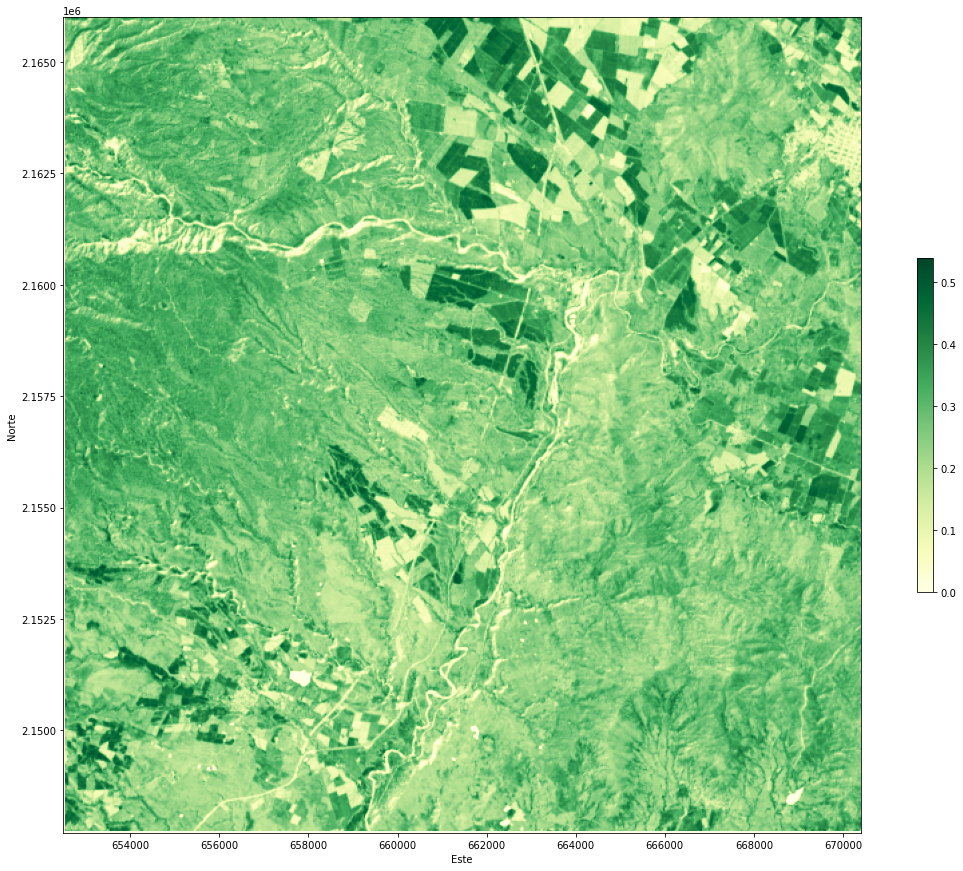

In [15]:
plotNDVI(path_NDVI_2014,extentArray,0,'YlGn')

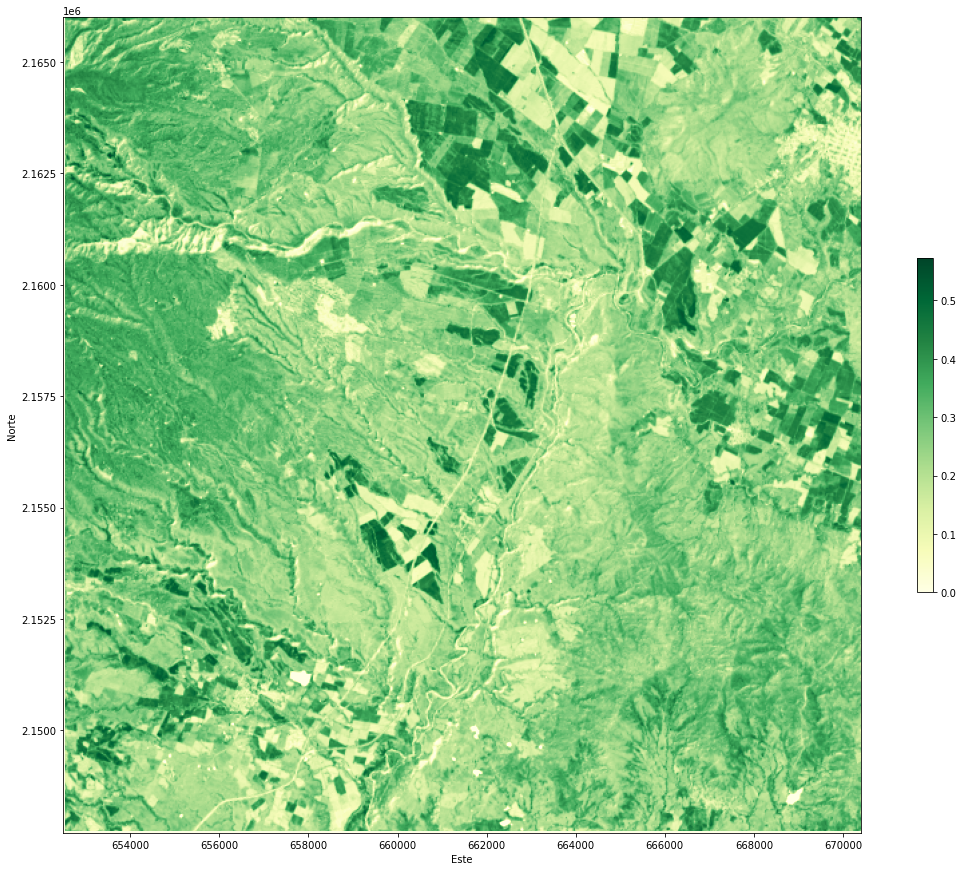

In [16]:
plotNDVI(path_NDVI_2019,extentArray,0,'YlGn')

## Create a land cover change image

We create a land cover change image based on the differences in NDVI from 2019 and 2014 imagery. The image will be stored as a separate file. 

In [17]:
ndviChange = ndvi2019-ndvi2014
ndviChange = np.where((ndvi2014>-999) & (ndvi2019>-999),ndviChange,-999)
ndviChange

array([[-9.9900000e+02,  3.5470784e-02,  3.7951261e-02, ...,
         3.1590372e-02,  3.8002759e-02,  2.6692629e-02],
       [-9.9900000e+02,  3.7654012e-02,  5.8923483e-02, ...,
        -5.8691800e-03,  1.8922418e-02,  1.9506305e-02],
       [-9.9900000e+02,  3.2184020e-02,  3.7395060e-02, ...,
        -6.3773081e-02, -3.0675709e-02,  3.8942695e-02],
       ...,
       [-9.9900000e+02, -1.6597062e-02,  1.1402190e-02, ...,
         2.7218461e-03,  2.5526762e-02,  6.6639006e-02],
       [-9.9900000e+02,  5.9944689e-03, -4.0770471e-03, ...,
         5.7501763e-02,  4.6757758e-03,  8.4484324e-02],
       [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
        -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]], dtype=float32)

In [18]:
saveRaster(ndviChange,path_NDVIChange_19_14,cols,rows,projection)

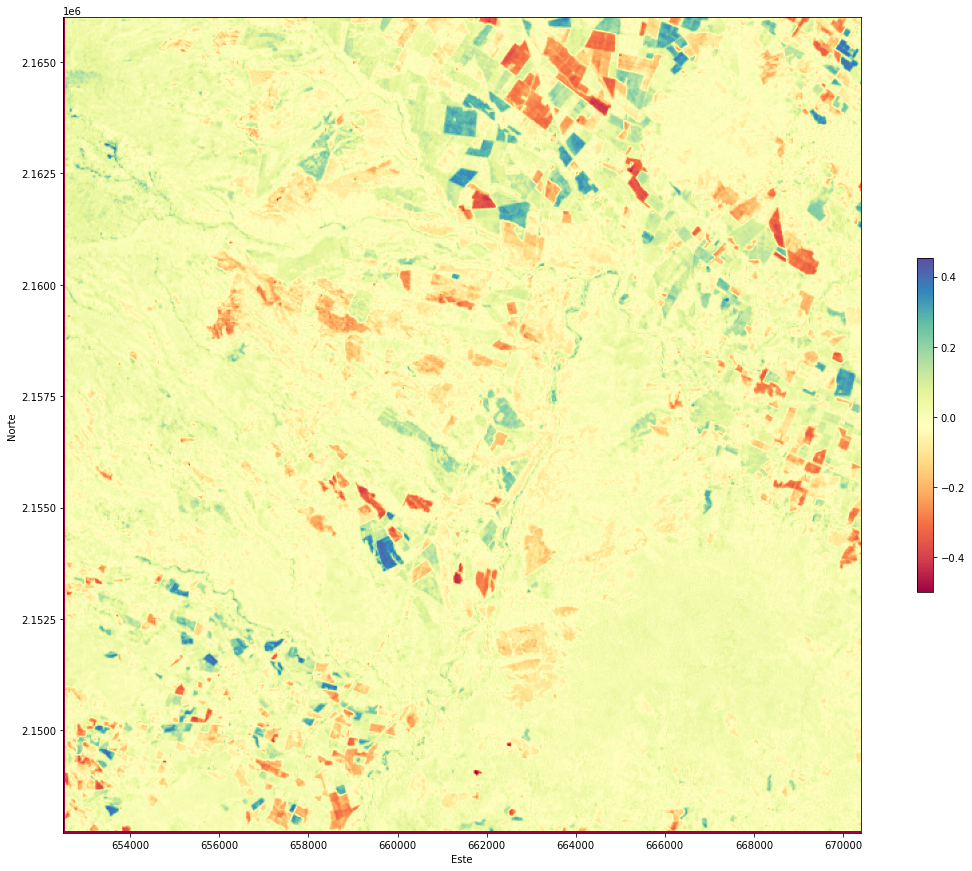

In [19]:
plotNDVI(path_NDVIChange_19_14,extentArray,-0.5,'Spectral')

## Create Contourlines
Finally, the countour lines from the NDVI values are generated. This is done with tool from the GDAL library.

In [20]:
Dataset_ndvi = gdal.Open(path_NDVIChange_19_14)#path_NDVI_2014
ndvi_raster = Dataset_ndvi.GetRasterBand(1)

ogr_ds = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contours_NDVIChange_19_14)

prj=Dataset_ndvi.GetProjectionRef()#GetProjection()

srs = osr.SpatialReference(wkt=prj)#
#srs.ImportFromProj4(prj)

contour_shp = ogr_ds.CreateLayer('contour', srs)
field_defn = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_shp.CreateField(field_defn)
field_defn = ogr.FieldDefn("ndviChange", ogr.OFTReal)
contour_shp.CreateField(field_defn)
#Generate Contourlines
gdal.ContourGenerate(ndvi_raster, 0.1, 0, [], 1, -999, contour_shp, 0, 1)
ogr_ds = None